# Pipeline to analyze the **Hospital Flux Networks**

1. Plotting;
2. Modularity detection through InfoMap.

## **Bib**

In [2]:
import os
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import geopandas as gpd

import networkx as nx
import matplotlib.pyplot as plt

#from fluxsus.fluxnets import FluxNets

## **Load data**

In [7]:
# -- input origin
datapath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
sihpath = os.path.join(datapath, "opendatasus", "sihsus", "PARQUET")
geopath = os.path.join(datapath, "shapefilesceqgis")
# -- output destination
gml_output = os.path.join(datapath, "redes_aih", "novo_completo")

### **SIHSUS** data

In [11]:
# -- define the range of years to aggregate the network
init_year = 2018
final_year = 2022
year_range = range(init_year, final_year+1)

In [12]:
sihsus_df = []
for year in year_range:
    sihsus_df.append( pd.read_parquet(os.path.join(sihpath, f"RDCE_{year}.parquet")) )
sihsus_df = pd.concat(sihsus_df)

In [13]:
print(sihsus_df.info())
sihsus_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2535152 entries, 0 to 44760
Data columns (total 21 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ESPEC       object 
 1   N_AIH       object 
 2   ANO_CMPT    object 
 3   CNES        object 
 4   IDENT       object 
 5   MUNIC_RES   object 
 6   MARCA_UTI   object 
 7   VAL_SH      float64
 8   VAL_SP      float64
 9   VAL_TOT     float64
 10  VAL_UTI     float64
 11  DT_INTER    object 
 12  DT_SAIDA    object 
 13  DIAG_PRINC  object 
 14  DIAG_SECUN  object 
 15  COBRANCA    object 
 16  NATUREZA    object 
 17  GESTAO      object 
 18  MUNIC_MOV   object 
 19  MORTE       int64  
 20  COMPLEX     object 
dtypes: float64(4), int64(1), object(16)
memory usage: 425.5+ MB
None


,ESPEC,N_AIH,ANO_CMPT,CNES,IDENT,MUNIC_RES,MARCA_UTI,VAL_SH,VAL_SP,VAL_TOT,...,DT_INTER,DT_SAIDA,DIAG_PRINC,DIAG_SECUN,COBRANCA,NATUREZA,GESTAO,MUNIC_MOV,MORTE,COMPLEX
0,01,2317107461779,2018,6779522,1,230730,00,103.70,55.96,159.66,...,20171215,20171216,Z470,0000,12,00,2,230730,0,02
1,01,2317107461900,2018,6779522,1,230550,00,1095.60,118.06,1213.66,...,20171211,20171228,T813,0000,12,00,2,230730,0,02
2,01,2317107461933,2018,6779522,1,230730,00,95.71,55.96,151.67,...,20171214,20171216,Z470,0000,12,00,2,230730,0,02
3,03,2317105347030,2018,6779522,1,230550,00,2055.87,64.38,2120.25,...,20171104,20171111,I638,0000,12,00,2,230730,0,02
4,03,2317105347073,2018,6779522,1,230190,00,1748.15,64.38,1812.53,...,20171104,20171108,I638,0000,12,00,2,230730,0,02


### **GEO** data

In [14]:
cres_df = gpd.read_file( os.path.join(geopath, "CRES.shp") )
mun_df = gpd.read_file( os.path.join(geopath, "Ceará MUN.shp") )
macro_df = gpd.read_file( os.path.join(geopath, "Macro Ceará.shp") )

macro_df["ID"] = macro_df["ID"].astype(int)
mun_df["GEO6"] = mun_df["GEO6"].astype(str)

mun_df1 = mun_df.merge(macro_df[["ID", "Macro Shee"]], left_on="MACRO", right_on="ID").drop("ID", axis=1).rename({"Macro Shee": "Macro Nome"}, axis=1)
mun_df1["centroid"] = mun_df1.centroid
mun_df1['lon'] = mun_df1['centroid'].apply(lambda x: x.x)
mun_df1['lat'] = mun_df1['centroid'].apply(lambda x: x.y)
mun_df1 = mun_df1.drop('centroid', axis=1)
mun_df1.head()

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_8316\3254487858.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_df1["centroid"] = mun_df1.centroid


,CD_GEOCODM,NM_MUNICIP,GEO6,MACRO,CRES,geometry,Macro Nome,lon,lat
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,-39.037538,-7.359907
1,2300309,ACOPIARA,230030,5,18,"POLYGON ((-39.21390 -5.99175, -39.21278 -5.991...",Superintendência Regional de Saúde Cariri,-39.492823,-6.122411
2,2300606,ALTANEIRA,230060,5,20,"POLYGON ((-39.70288 -6.97367, -39.69772 -6.961...",Superintendência Regional de Saúde Cariri,-39.698883,-6.985781
3,2300804,ANTONINA DO NORTE,230080,5,20,"POLYGON ((-40.03288 -6.73521, -40.03228 -6.734...",Superintendência Regional de Saúde Cariri,-39.981590,-6.756665
4,2301307,ARARIPE,230130,5,20,"POLYGON ((-40.26119 -7.14280, -40.26119 -7.142...",Superintendência Regional de Saúde Cariri,-40.076659,-7.239024


## **Build the flux networks**

In [15]:
flux = FluxNets(sihsus_df, mun_df1)

In [16]:
flux.build_flux_network(icd_chapter=None)
print(f'Edges: {len(flux.G.edges)}\nNodes: {len(flux.G.nodes)}')
flux.to_gml(os.path.join(gml_output, f"FLUX_AIH_{init_year}_{final_year}_ALL.gml"))

Edges: 3382
Nodes: 184


In [1135]:
cur_chapter = "I"
flux.build_flux_network(icd_chapter=cur_chapter)
print(f'Edges: {len(flux.G.edges)}\nNodes: {len(flux.G.nodes)}')
flux.to_gml(os.path.join(gml_output, f"FLUX_AIH_{init_year}_{final_year}_CH_{cur_chapter}.gml"))

Edges: 721
Nodes: 184


In [1136]:
cur_chapter = "II"
flux.build_flux_network(icd_chapter=cur_chapter)
print(f'Edges: {len(flux.G.edges)}\nNodes: {len(flux.G.nodes)}')
flux.to_gml(os.path.join(gml_output, f"FLUX_AIH_{init_year}_{final_year}_CH_{cur_chapter}.gml"))

Edges: 463
Nodes: 184


In [1137]:
cur_chapter = "V"
flux.build_flux_network(icd_chapter=cur_chapter)
print(f'Edges: {len(flux.G.edges)}\nNodes: {len(flux.G.nodes)}')
flux.to_gml(os.path.join(gml_output, f"FLUX_AIH_{init_year}_{final_year}_CH_{cur_chapter}.gml"))

Edges: 260
Nodes: 180


In [1138]:
cur_chapter = "IX"
flux.build_flux_network(icd_chapter=cur_chapter)
print(f'Edges: {len(flux.G.edges)}\nNodes: {len(flux.G.nodes)}')
flux.to_gml(os.path.join(gml_output, f"FLUX_AIH_{init_year}_{final_year}_CH_{cur_chapter}.gml"))

Edges: 617
Nodes: 184


In [1139]:
cur_chapter = "X"
flux.build_flux_network(icd_chapter=cur_chapter)
print(f'Edges: {len(flux.G.edges)}\nNodes: {len(flux.G.nodes)}')
flux.to_gml(os.path.join(gml_output, f"FLUX_AIH_{init_year}_{final_year}_CH_{cur_chapter}.gml"))

Edges: 571
Nodes: 184


## **Plots**

In [4]:
init_year = 2018
final_year = 2022

### **Circos Plot**

In [5]:
import nxviz as nv
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [35]:
# -- logarithm scaling of edge fluxes.
def logrank(data : pd.Series, max_power_base10 : int, number_of_bins=12):
    logspace = np.logspace(0, max_power_base10, number_of_bins, base=10)
    return data.apply(lambda x: np.argmax(logspace > x)  ) # index of the first true

# -- custom coloring for circos plot
def group_colormap_macro(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c", -1: "#9c9c9c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges_transparency(data : pd.Series):
    cmap = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, -1: 1}
    return data.apply(lambda x: cmap.get(x))

def value_colormap(data: pd.Series):
    """Value colormap."""
    norm = plt.cm.Normalize(vmin=data.min(), vmax=data.max())
    cmap = plt.cm.get_cmap("viridis")
    return data.apply(lambda x: cmap(norm(x)))

def node_size(data: pd.Series):
    return data.apply(np.sqrt)

In [36]:
# -- open graph
fname = f"cityfluxnet_agg_1801_2212.gml"
G = nx.read_gml(os.path.join(gml_output, fname))

# -- simplify names
for node in G.nodes():
    G.nodes[node]['macro_name'] = G.nodes[node]['macro_name'].replace("Superintendência Regional de Saúde ", "")

# -- get node and edge attributes as dataframes
nt = node_table(G)
et = edge_table(G)

In [37]:
et

,admission_count,total_cost,source_macro,target_macro,source_micro,target_micro,same_macro,same_micro,admission_count_ch1,total_cost_ch1,...,admission_count_ch19,total_cost_ch19,admission_count_ch20,total_cost_ch20,admission_count_ch21,total_cost_ch21,admission_count_ch22,total_cost_ch22,source,target
0,27,16354.65,5.0,5,19.0,19,5.0,19.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0,19
1,330,822005.77,5.0,5,19.0,21,5.0,-1.0,9.0,65613.60,...,56.0,21388.40,0.0,0.0,0.0,0.00,0.0,0.00,0,22
2,1326,1014636.00,5.0,5,19.0,19,5.0,19.0,145.0,261537.91,...,230.0,167397.61,0.0,0.0,18.0,4611.24,0.0,0.00,0,30
3,4,5397.82,5.0,5,19.0,20,5.0,-1.0,1.0,2894.54,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0,50
4,1,588.63,5.0,5,19.0,20,5.0,-1.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,4,2088.32,4.0,4,13.0,13,4.0,13.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,183,160
3378,3181,8350342.70,4.0,4,13.0,11,4.0,-1.0,289.0,1821299.32,...,665.0,1615848.37,0.0,0.0,59.0,25453.22,0.0,0.00,183,166
3379,2450,2629498.92,4.0,4,13.0,13,4.0,13.0,166.0,1340763.07,...,556.0,286950.33,0.0,0.0,27.0,4469.82,2.0,91.49,183,173
3380,2,577.64,4.0,4,13.0,13,4.0,13.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,183,176


In [38]:
chapter = "ch2"

# -- logarithm scaling of edge fluxes.
# ---- get the highest exponent of the fluxes in the base 10.
max_power_base10 = np.ceil(np.log10(np.abs(et[f'admission_count_{chapter}'].max()))) 
print(f'Highest exponent (base 10) of flux count: {max_power_base10}')
et['edge_log_weight'] = logrank(et[f'admission_count_{chapter}'], max_power_base10, number_of_bins=12)/logrank(et[f'admission_count_{chapter}'], max_power_base10, number_of_bins=12).max()

# ---- simple scaling
scaler = 1.5
et['edge_log_weight'] = et['edge_log_weight']*scaler
# ---- highlight higher fluxes
et['edge_log_weight'] = et['edge_log_weight'].apply(lambda x: x*5.0 if x>(0.70*scaler) else x)


# ---- custom scaling
#et['edge_log_weight'] = et[['edge_log_weight', 'same_ads']].apply(lambda x: x['edge_log_weight']*2 if x['edge_log_weight']>0.50 and x['same_ads']!='-1' else x['edge_log_weight']*0.2, axis=1)

print(f'Maximum rescaled weight: {et["edge_log_weight"].max()}\nMinimum rescaled weight: {et["edge_log_weight"].min()}')

Highest exponent (base 10) of flux count: 4.0
Maximum rescaled weight: 7.5
Minimum rescaled weight: 0.0


Create plot

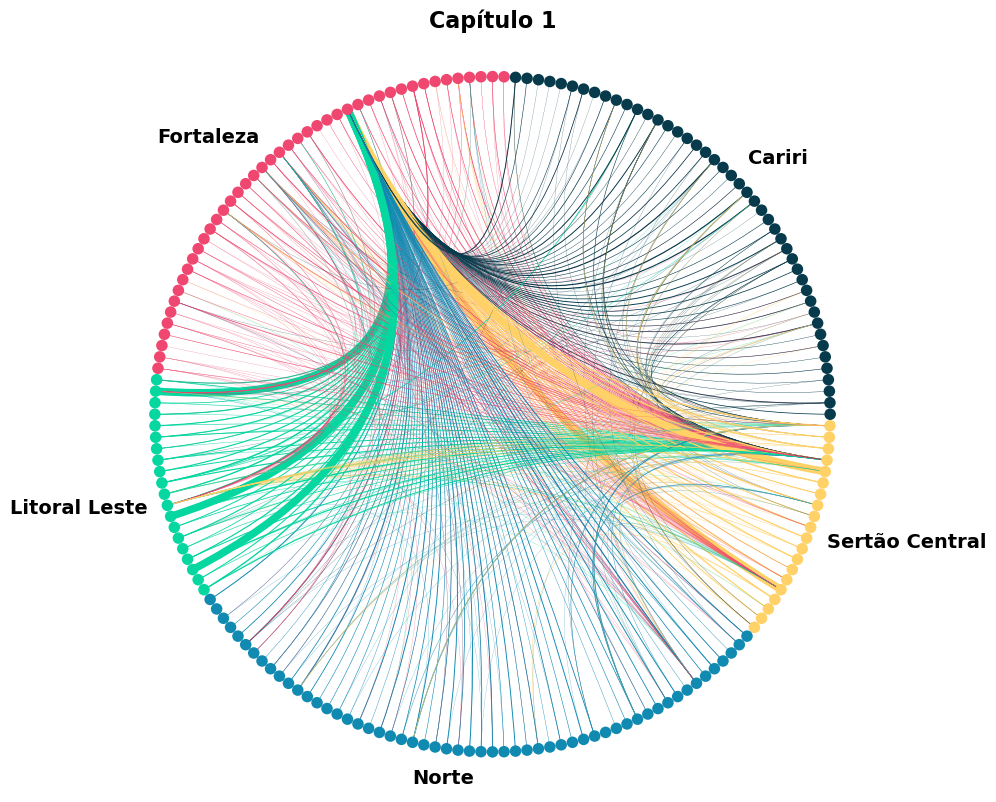

In [51]:
# -- WITH NUMBERS

fig_circos, ax_circos = plt.subplots(1, figsize=(10,10))

# -- node styling
pos = layouts.circos(nt, group_by="macro_name", sort_by="macro_name")
annotate.circos_group(G, group_by="macro_name", ax=ax_circos, radius_offset=3, fontdict={'size': 14, 'weight': 'bold' })
node_color = group_colormap_macro(nt["macro_id"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, size_by=None)
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax_circos.add_patch(patch)

# -- edge styling
#edge_color = edges.edge_colors(et, nt=None, color_by=edge_color_hash, node_color_by=None)
edge_color = group_colormap_edges(et["source_macro"])
edge_linewidth = et["edge_log_weight"]
alpha = group_colormap_edges_transparency(et["same_macro"])
patches = lines.circos(
    et, pos, edge_color=edge_color, alpha=alpha, lw=edge_linewidth, aes_kw={"fc": "none"}
)
for patch in patches:
    ax_circos.add_patch(patch)

rescale(G)
aspect_equal()
despine()

ax_circos.set_title(f"Capítulo {chapter.split('ch')[1]}", fontsize=16, weight='bold')
fig_circos.tight_layout()
fig_circos.savefig(os.path.join(datapath, "redes_aih", "doc_final", f"flux_circular_{chapter}_1801_2212.png"), format="png", dpi=250, bbox_inches="tight")


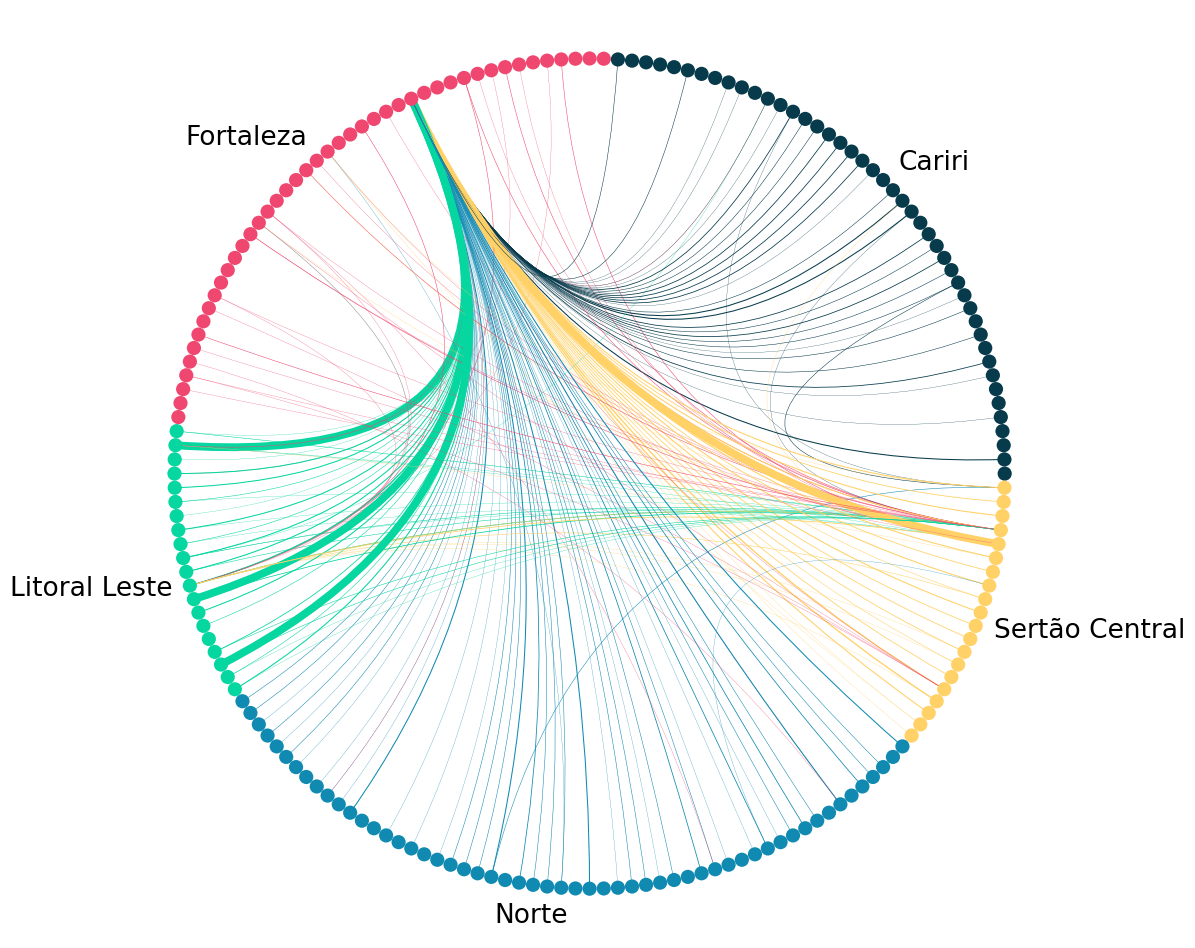

In [200]:
# -- WITH NAMES

fig_circos, ax_circos = plt.subplots(1, figsize=(12,12))

# -- node styling
pos = layouts.circos(nt, group_by="macro_name", sort_by="macro_name")
annotate.circos_group(G, group_by="macro_name", ax=ax_circos, radius_offset=2, fontdict={'size': 19})
node_color = group_colormap_macro(nt["macro_id"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, size_by=None)
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax_circos.add_patch(patch)

# -- edge styling
#edge_color = edges.edge_colors(et, nt=None, color_by=edge_color_hash, node_color_by=None)
edge_color = group_colormap_edges(et["same_ads"])
edge_linewidth = et["edge_log_weight"]
alpha = group_colormap_edges_transparency(et["same_ads"])
patches = lines.circos(
    et, pos, edge_color=edge_color, alpha=alpha, lw=edge_linewidth, aes_kw={"fc": "none"}
)
for patch in patches:
    ax_circos.add_patch(patch)

rescale(G)
aspect_equal()
despine()

fig_circos.tight_layout()
fig_circos.savefig(os.path.join(gml_output, "FIGURAS", fname.split(".")[0]+"_CIRCOS_NAMES.png"), format="png", dpi=350, bbox_inches="tight")

In [190]:
macro_df

,ID,Macro Shee,geometry
0,5,Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707..."
1,1,Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ..."
2,2,Superintendência Regional de Saúde Sertão Central,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370..."
3,3,Superintendência Regional de Saúde Litoral Leste,"POLYGON ((-37.77077 -4.42713, -37.76948 -4.426..."
4,4,Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ..."


## **Geographical network**

In [359]:
# -- open graph
fname_geo = f"FLUX_AIH_{init_year}_{final_year}_ALL.gml"
G_geo = nx.read_gml(os.path.join(gml_output, fname_geo))

In [360]:
cmap_macro = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}
mun_df1['MACRO_COLOR'] = mun_df1["MACRO"].map(cmap_macro)
macro_df['MACRO_COLOR'] = macro_df["ID"].map(cmap_macro)
mun_df1.head()

,CD_GEOCODM,NM_MUNICIP,GEO6,MACRO,CRES,geometry,Macro Nome,lon,lat,MACRO_COLOR
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,-39.037538,-7.359907,#073b4c
1,2300309,ACOPIARA,230030,5,18,"POLYGON ((-39.21390 -5.99175, -39.21278 -5.991...",Superintendência Regional de Saúde Cariri,-39.492823,-6.122411,#073b4c
2,2300606,ALTANEIRA,230060,5,20,"POLYGON ((-39.70288 -6.97367, -39.69772 -6.961...",Superintendência Regional de Saúde Cariri,-39.698883,-6.985781,#073b4c
3,2300804,ANTONINA DO NORTE,230080,5,20,"POLYGON ((-40.03288 -6.73521, -40.03228 -6.734...",Superintendência Regional de Saúde Cariri,-39.981590,-6.756665,#073b4c
4,2301307,ARARIPE,230130,5,20,"POLYGON ((-40.26119 -7.14280, -40.26119 -7.142...",Superintendência Regional de Saúde Cariri,-40.076659,-7.239024,#073b4c


In [361]:
macro_df

,ID,Macro Shee,geometry,MACRO_COLOR
0,5,Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...",#073b4c
1,1,Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...",#ef476f
2,2,Superintendência Regional de Saúde Sertão Central,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...",#ffb300
3,3,Superintendência Regional de Saúde Litoral Leste,"POLYGON ((-37.77077 -4.42713, -37.76948 -4.426...",#04ae81
4,4,Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...",#118ab2


Highest exponent (base 10) of in-degree: 3.0
Maximum rescaled node size: 60
Minimum rescaled node size: 6
Highest exponent (base 10) of edge flux: 5.0
Maximum rescaled edge width: 0.8727272727272727
Minimum rescaled edge width: 0.0


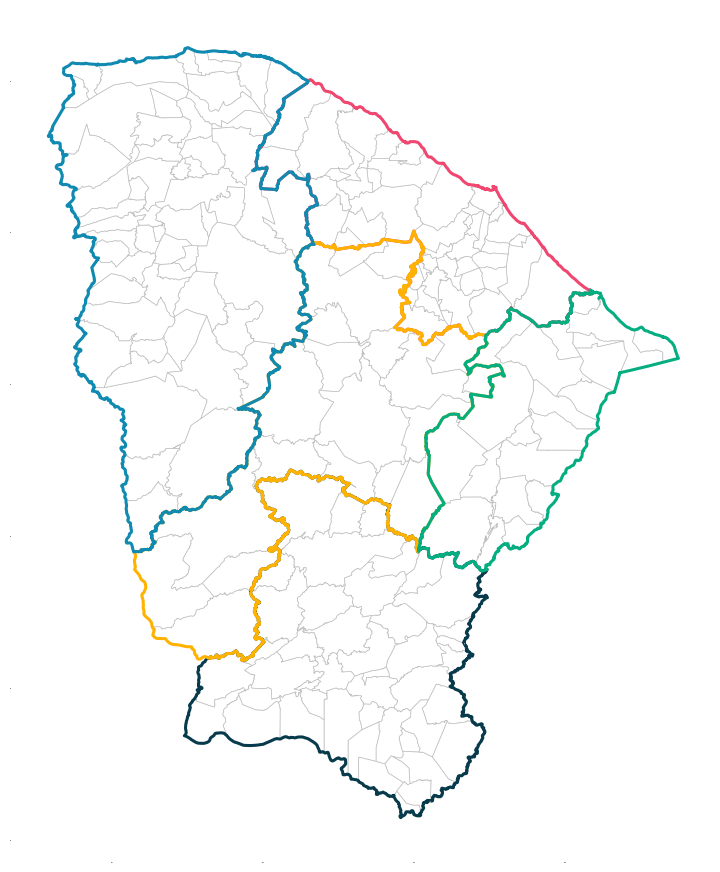

In [377]:
# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(12,11))

mun_df1.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
macro_df.plot(ax=ax1, color="none", edgecolor=macro_df["MACRO_COLOR"], linewidth=2.2)

for i in ['left', 'right', 'top', 'bottom']:
    ax1.spines[i].set_linewidth(0)

ax1.tick_params(which='both', length=0, labelsize=0)

# -- spatial coordinates for nodes' position
geopos_net = {}
for v in G_geo.nodes():
    geopos_net.update( {v: np.array([G_geo.nodes[v]['lon'], G_geo.nodes[v]['lat']])} )

# -- LAYOUT
# -- node size
in_deg_lst = pd.Series([ in_degree[1] for in_degree in G_geo.in_degree ]) 

max_power_base10 = np.ceil(np.log10(np.abs(in_deg_lst.max())))
print(f'Highest exponent (base 10) of in-degree: {max_power_base10}')

# -- node size scaling
prop_scale = 6
in_deg_logrank = (logrank(in_deg_lst, max_power_base10, number_of_bins=12) + 1)*prop_scale

print(f'Maximum rescaled node size: {in_deg_logrank.max()}\nMinimum rescaled node size: {in_deg_logrank.min()}')


# -- node color
cmap_macro_str = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c"}
cmap_macro_str = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c"}
color_nodes = [ cmap_macro_str[G_geo.nodes[v]['macro_id']] for v in G_geo.nodes() ]

# -- edge color
cmap_edge_color = {'1': "#ef476f", '2': "#ffd166", '3': "#06d6a0", '4': "#118ab2", '5': "#073b4c", "-1": "#9c9c9c"}
cmap_edge_color = {'1': "#ef476f", '2': "#ffb300", '3': "#04ae81", '4': "#118ab2", '5': "#073b4c", "-1": "#404040"}
# ---- INTER
edge_colors = [ cmap_edge_color[G_geo.edges[u,v]['same_ads']] for u, v in G_geo.edges() ]
# ---- INTRA
#edge_colors = [ cmap_macro_str[G_geo.nodes[u]['macro_id']] for u, v in G_geo.edges() ]

# -- edge width

weight_edge = pd.Series([ G_geo.edges[u,v]['count'] for u,v in G_geo.edges ]) 
max_power_base10_count = np.ceil(np.log10(np.abs(weight_edge.max())))
print(f'Highest exponent (base 10) of edge flux: {max_power_base10_count}')

weight_edge = ( logrank(weight_edge, max_power_base10, number_of_bins=12) + 1)/logrank(weight_edge, max_power_base10, number_of_bins=12).max()

# -- simple scaling
weight_edge = weight_edge*0.8

# -- custom scaling (Only intra macrorregions)
#for index, (u,v) in enumerate(G_geo.edges):
#    if G_geo.edges[u,v]['same_ads']!='-1':
#            weight_edge[index] = 0.00
    #elif weight_edge[index]<=weight_edge.max()*0.70:
    #    weight_edge[index]*=0.3

# -- custom scaling (Only inter macrorregions)
for index, (u,v) in enumerate(G_geo.edges):
    if G_geo.edges[u,v]['same_ads']=='-1':
            weight_edge[index] = 0.00
    elif weight_edge[index]<=weight_edge.max()*0.70:
        weight_edge[index]*=0.5


print(f'Maximum rescaled edge width: {weight_edge.max()}\nMinimum rescaled edge width: {weight_edge.min()}')


#for index, (u,v) in enumerate(G_geo.edges):
#    if weight_edge[index]>0.5 and G_geo.edges[u,v]['same_ads']!='-1':
#        weight_edge[index]*=1.0
#    else:
#        weight_edge[index]*=0.6

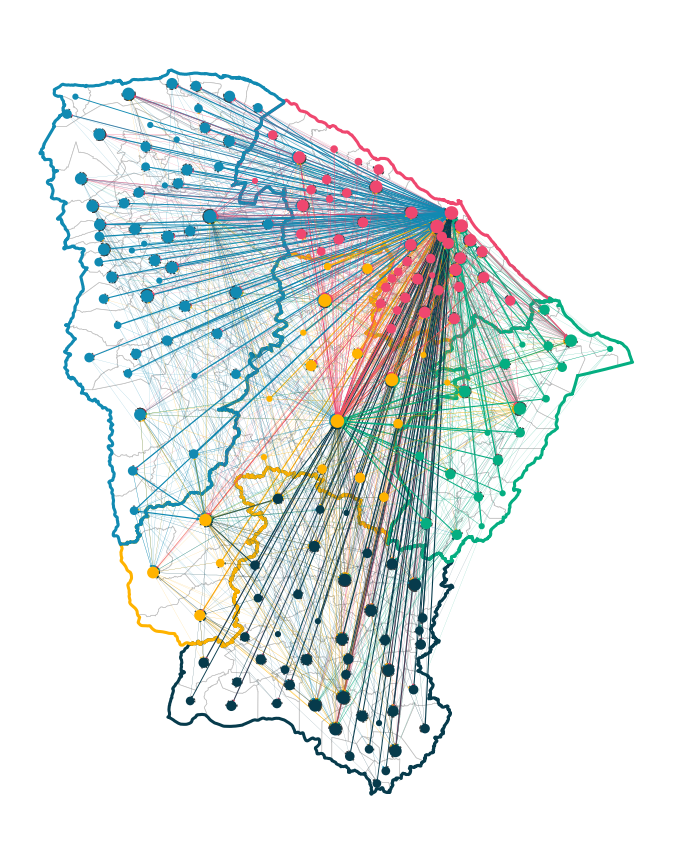

In [378]:
nx.draw(G_geo, pos=geopos_net, ax=ax1, arrows=True, arrowsize=4, node_size=in_deg_logrank, node_color=color_nodes, edge_color=edge_colors, width=weight_edge, alpha=1.0, linewidths=2)
fig1

In [380]:
#fig1.savefig(os.path.join(gml_output, "FIGURAS", fname_geo.split(".")[0]+"_MAP_INTER.png"), dpi=350, bbox_inches="tight")

### **Force Atlas Network**

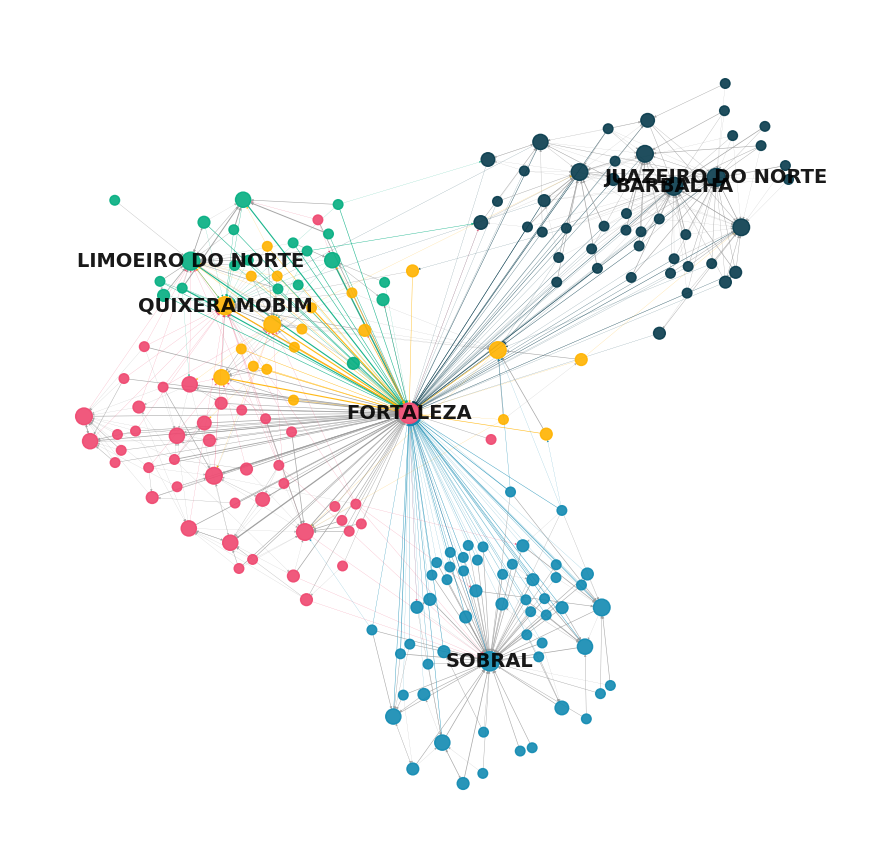

In [1047]:
fname_geo_1 = "FLUX_AIH_2013_2022_CH_X_POS.gml"
G_pos = nx.read_gml(os.path.join(gml_output, fname_geo_1))

positions = {}
for v in G_pos.nodes:
    positions.update({v: np.array([G_pos.nodes[v]['graphics']['x'], G_pos.nodes[v]['graphics']['y']])})



nome = {}
for v in G_pos.nodes:
    if in_deg_logrank[int(v)] >= in_deg_logrank.max()-8:
        nome.update({v: G_pos.nodes[v]['municipio_name']})
    else:
        nome.update({v: ''})


fig2, ax2 = plt.subplots(1, figsize=(11,11))

for i in ['left', 'right', 'top', 'bottom']:
    ax2.spines[i].set_linewidth(0)

ax2.tick_params(which='both', length=0, labelsize=0)

#pos_spring = nx.spring_layout(G_geo, k=None, iterations=200, weight='count')

nx.draw(G_geo, pos=positions, ax=ax2, arrows=True, arrowsize=3.5, node_size=in_deg_logrank*6, node_color=color_nodes, edge_color=edge_colors, width=weight_edge*1.5, labels=nome, font_weight='bold', font_size=14, alpha=0.9)

In [1048]:
fig2.savefig(os.path.join(datapath, 'networkx_gml', fname_geo.split(".")[0]+"_FORCE.png"), dpi=350, bbox_inches="tight")

In [925]:
G_pos.nodes[node]

{'graphics': {'x': 314.915,
  'y': 147.83495,
  'z': 0.0,
  'w': 10.0,
  'h': 10.0,
  'd': 10.0,
  'fill': '#000000'},
 'municipio_code': '231410',
 'municipio_name': 'VIÇOSA DO CEARÁ',
 'macro_id': '4',
 'macro_name': 'Superintendência Regional de Saúde Norte',
 'cres_id': '13',
 'lat': '-3.5450734133203823',
 'lon': '-41.13613634135282'}

In [ ]:
geopos_net = {}
for v in G_geo.nodes():
    geopos_net.update( {v: np.array([G_geo.nodes[v]['lon'], G_geo.nodes[v]['lat']])} )

### **City shape plot**

In [1068]:
mun_df1[mun_df1["NM_MUNICIP"]=="RUSSAS"]

,CD_GEOCODM,NM_MUNICIP,GEO6,MACRO,CRES,geometry,Macro Nome,lon,lat,MACRO_COLOR
181,2311801,RUSSAS,231180,3,9,"POLYGON ((-38.28868 -4.66580, -38.28868 -4.665...",Superintendência Regional de Saúde Litoral Leste,-38.151086,-4.842977,#04ae81


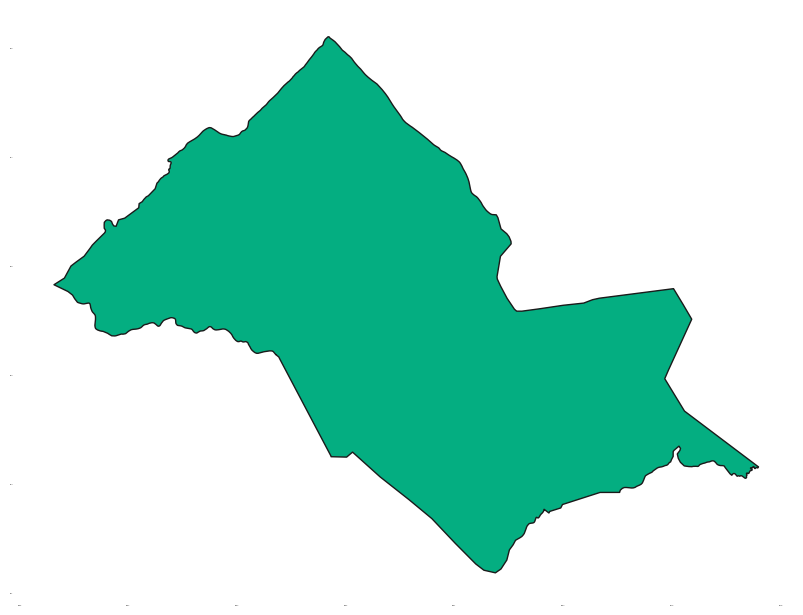

In [1069]:
fig_quixeramobim, ax_quix = plt.subplots(1, figsize=(10,10))

mun_df1[mun_df1["NM_MUNICIP"]=="RUSSAS"].plot(ax=ax_quix, color="#04ae81", edgecolor="#1a1a1a")


for i in ['left', 'right', 'top', 'bottom']:
    ax_quix.spines[i].set_linewidth(0)

ax_quix.tick_params(which='both', length=0, labelsize=0)
fig_quixeramobim.savefig(os.path.join(datapath, 'networkx_gml', "LIMOEIRO DO RUSSAS.png"), dpi=350, bbox_inches="tight")

,CD_GEOCODM,NM_MUNICIP,GEO6,MACRO,CRES,geometry,Macro Nome,lon,lat,MACRO_COLOR
160,2311405,QUIXERAMOBIM,231140,2,8,"POLYGON ((-39.35523 -4.98257, -39.35523 -4.982...",Superintendência Regional de Saúde Sertão Central,-39.330248,-5.243853,#ffb300


## **INFOMAP**

In [354]:
from infomap import Infomap

In [355]:
fname_infomap = f"FLUX_AIH_{init_year}_{final_year}_CH_IX.gml"
G_infomap = nx.read_gml(os.path.join(gml_output, fname_infomap))

In [356]:
# Command line flags can be added as a string to Infomap
im = Infomap(directed=True)

# add nodes
for n in range(G_infomap.number_of_nodes()):
    im.add_node(n)

# add links
for u, v in G_infomap.edges():
    im.add_link(int(u),int(v), G_infomap.edges[u,v]['count'])

im.run()

print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

# -- hash node -> module
node_module = {}
for node in im.tree:
    node_module.update({node.node_id: node.module_id})

# -- include new modularization
for u in G_infomap.nodes():
    G_infomap.nodes[u]['municipio_module_id'] = node_module[int(u)]

mun_module_df = node_table(G_infomap)[["municipio_code", "municipio_module_id"]].copy()
mun_module_df.head()

Found 9 modules with codelength: 2.501317306017876


,municipio_code,municipio_module_id
0,230010,9
1,230015,6
2,230020,1
3,230030,2
4,230040,3


In [357]:
mun_df2 = mun_df1.merge(mun_module_df, left_on="GEO6", right_on="municipio_code", how="left")
mun_df2.head()

,CD_GEOCODM,NM_MUNICIP,GEO6,MACRO,CRES,geometry,Macro Nome,lon,lat,MACRO_COLOR,municipio_code,municipio_module_id
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,-39.037538,-7.359907,#073b4c,230010,9
1,2300309,ACOPIARA,230030,5,18,"POLYGON ((-39.21390 -5.99175, -39.21278 -5.991...",Superintendência Regional de Saúde Cariri,-39.492823,-6.122411,#073b4c,230030,2
2,2300606,ALTANEIRA,230060,5,20,"POLYGON ((-39.70288 -6.97367, -39.69772 -6.961...",Superintendência Regional de Saúde Cariri,-39.698883,-6.985781,#073b4c,230060,2
3,2300804,ANTONINA DO NORTE,230080,5,20,"POLYGON ((-40.03288 -6.73521, -40.03228 -6.734...",Superintendência Regional de Saúde Cariri,-39.981590,-6.756665,#073b4c,230080,2
4,2301307,ARARIPE,230130,5,20,"POLYGON ((-40.26119 -7.14280, -40.26119 -7.142...",Superintendência Regional de Saúde Cariri,-40.076659,-7.239024,#073b4c,230130,2


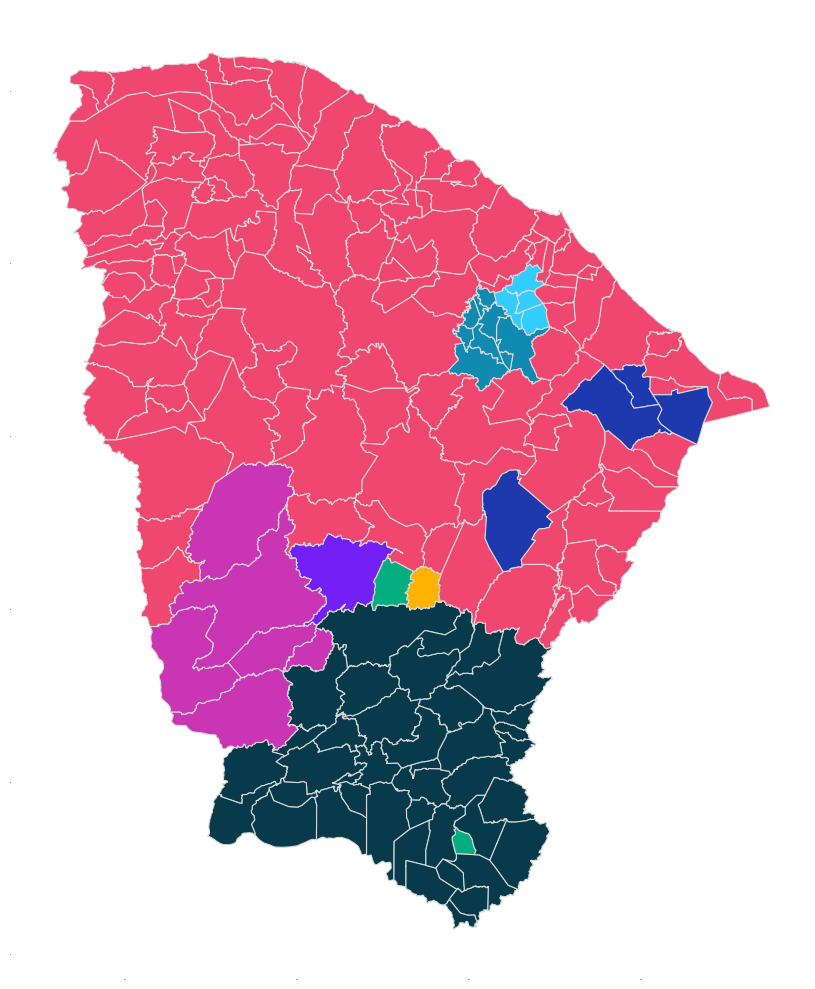

In [358]:
# -- new geometry ceará
fig_new, ax_new = plt.subplots(1, figsize=(12,10))

#cmap_new = {1: "#b4ddd4", 2: "#294d46", 3: "#39eec0", 4: "#056e12", 5: "#a0e85b", 6: "#773493", 7: "#cf84cb", 8: "#49406e", 9: "#ef66f0"}
cmap_new_all = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81"}
cmap_new_ch1 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81", 10: "#fca5cf"}
cmap_new_ch2 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4"}
cmap_new_ch9 = {1: "#ef476f", 2: "#073b4c", 3: "#ca35b4", 4: "#1e39ae", 5: "#118ab2", 6: "#33ccff", 7: "#7220f6", 8: "#ffb300", 9: "#04ae81"}
facecolors = mun_df2["municipio_module_id"].map(cmap_new_ch9)

#mun_df1.plot(ax=ax_new, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
mun_df2.plot(ax=ax_new, color=facecolors, edgecolor="#d9d9d9", linewidth=0.8)
#macro_df.plot(ax=ax1, color="none", edgecolor=macro_df["MACRO_COLOR"], linewidth=1.5)

for i in ['left', 'right', 'top', 'bottom']:
    ax_new.spines[i].set_linewidth(0)

ax_new.tick_params(which='both', length=0, labelsize=0)

fig_new.tight_layout()
fig_new.savefig(os.path.join(gml_output, "FIGURAS", fname_infomap.split(".")[0]+"_INFOMAP.png"), dpi=300, bbox_inches='tight')

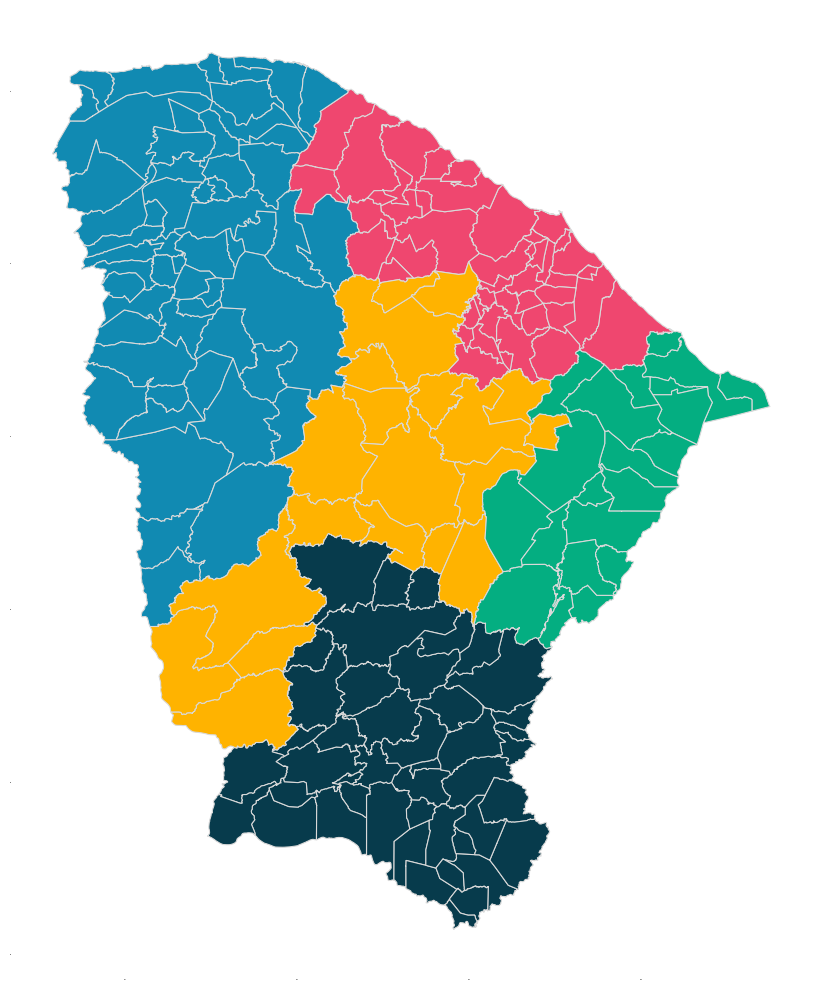

In [341]:
# -- old geometry ceará
fig_old, ax_old = plt.subplots(1, figsize=(12,10))

mun_df1.plot(ax=ax_old, color=mun_df1["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
#macro_df.plot(ax=ax1, color="none", edgecolor=macro_df["MACRO_COLOR"], linewidth=1.5)

for i in ['left', 'right', 'top', 'bottom']:
    ax_old.spines[i].set_linewidth(0)

ax_old.tick_params(which='both', length=0, labelsize=0)

fig_old.tight_layout()
fig_old.savefig(os.path.join(gml_output, "FIGURAS", fname_infomap.split(".")[0]+"_INFOMAP_ORIGINAL.png"), dpi=300, bbox_inches='tight')